In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
##Add decomposed components: PCA / ICA etc.
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## 1. Load

In [2]:
# load data
train = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/train.csv")
test = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/test.csv")

In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train.shape, test.shape)

(4209, 378) (4209, 377)


## 2. TargetMean

In [5]:
cols_cat = train.select_dtypes(include = ['object']).columns.values

In [6]:
# # oof to encode cols_cat with TargetMean
# def getTargetMean(dt, dt_all, cols, k = 3):

#     # init dt_targetMean
#     dt_targetMean = pd.DataFrame()

#     for col in cols:
    
#         # init dt_targetMean_oof
#         dt_targetMean_oof = pd.DataFrame()
        
#         # X_targetMean_Kfold, y_targetMean_Kfold
#         X_targetMean_Kfold = dt[[col, "y"]]
#         y_targetMean_Kfold = dt[col].values

#         # oof cv
# #         skf = StratifiedKFold(n_splits = k)
#         kf = KFold(n_splits = k)
        
        
# #         for i, (ind_in, ind_out) in enumerate(skf.split(X_targetMean_Kfold, y_targetMean_Kfold)):
#         for i, (ind_in, ind_out) in enumerate(kf.split(X_targetMean_Kfold)):

#             # init dt_targetMean_oof
#             dt_targetMean_val = pd.DataFrame()

#             # X_in, X_out, y_in, y_out
#             X_in, X_out = X_targetMean_Kfold.iloc[ind_in], X_targetMean_Kfold.iloc[ind_out]
#             y_in, y_out = y_targetMean_Kfold[ind_in], y_targetMean_Kfold[ind_out]

#             # calc TargetMean
#             for val in set(X_in[col].values):
#                 dt_targetMean_temp = pd.DataFrame({"Value": [val]
#                                                    , "TargetMean_" + str(i): [X_in.loc[X_in[col] == val].y.mean()]})
#                 dt_targetMean_val = pd.concat([dt_targetMean_val, dt_targetMean_temp])

#             # merge with oof
#             if i == 0:
#                 dt_targetMean_oof = pd.merge(X_targetMean_Kfold.drop("y", axis = 1).drop_duplicates(), dt_targetMean_val
#                                              , how = "left", left_on = col, right_on = "Value")
#                 dt_targetMean_oof = dt_targetMean_oof.drop(col, axis = 1)
#             else:
#                 dt_targetMean_oof = pd.merge(dt_targetMean_oof, dt_targetMean_val
#                                              , how = "left", on = "Value")

#         # move Value to the first column
#         value = dt_targetMean_oof['Value']
#         dt_targetMean_oof.drop(labels = ["Value"], axis = 1,inplace = True)
#         dt_targetMean_oof.insert(0, 'Value', value)
#         # assign col
#         dt_targetMean_oof.insert(0, 'Col', col)
        
#         # concat with col
#         dt_targetMean = pd.concat([dt_targetMean, dt_targetMean_oof])
    
#     # mean of oof
#     dt_targetMean["TargetMean"] = dt_targetMean.filter(regex = "TargetMean").mean(axis = 1)
#     # fill zero
#     dt_targetMean = dt_targetMean.fillna(0)
#     # remove oof cols
#     dt_targetMean = dt_targetMean[["Col", "Value", "TargetMean"]]

#     # merge to original table
#     dt_cat_cols = dt_all[cols]
    
#     for col in cols_cat:
#         dt_cat_cols = pd.merge(dt_cat_cols, dt_targetMean.loc[dt_targetMean["Col"] == col]
#                            , how = "left", left_on = col, right_on = "Value")
#         dt_cat_cols = dt_cat_cols.drop(["Value", "Col"], axis = 1)
#         dt_cat_cols = dt_cat_cols.rename(columns = {"TargetMean": "Encode_TargetMean_" + col})
#     # fill zero
#     dt_cat_cols = dt_cat_cols.fillna(0)
    
#     # only select targetMean cols
#     dt_cat_targetMean = dt_cat_cols.filter(regex = "Encode_TargetMean_")
        
#     return dt_cat_targetMean

In [7]:
# ## remove the outlier and tm
# dt_cat_targetMean_train = getTargetMean(train
#                                   , train
#                                   , cols_cat
#                                   , 10)
# dt_cat_targetMean_test = getTargetMean(train
#                                   , test
#                                   , cols_cat
#                                   , 10)

In [8]:
# train = train.join(dt_cat_targetMean_train)
# test = test.join(dt_cat_targetMean_test)

In [9]:
for c in cols_cat:
    x = train.groupby([c])["y"].mean()
    dt_targetMean_c = pd.DataFrame({c: x.index
                                   , "TargetMean_" + c: x.values})
    train = pd.merge(train, dt_targetMean_c, on = c)
    test = pd.merge(test, dt_targetMean_c, on = c)

In [10]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X384,X385,TargetMean_X0,TargetMean_X1,TargetMean_X2,TargetMean_X3,TargetMean_X4,TargetMean_X5,TargetMean_X6,TargetMean_X8
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,99.491818,101.412574,104.218333,102.507477,100.658293,130.810000,101.165245,97.746933
1,5761,115.07,o,l,ae,f,d,p,j,o,...,0,0,94.618699,100.725237,97.463569,96.564507,100.658293,100.859471,101.165245,97.746933
2,5883,77.38,bc,v,ac,f,d,p,j,o,...,0,0,76.195000,101.412574,88.880769,96.564507,100.658293,100.859471,101.165245,97.746933
3,4275,111.21,x,aa,b,c,d,l,j,o,...,0,0,112.555333,100.202701,96.878571,101.959269,100.658293,99.657436,101.165245,97.746933
4,7348,103.70,m,v,as,c,d,v,j,o,...,0,0,94.717941,101.412574,103.732453,101.959269,100.658293,99.782987,101.165245,97.746933


In [11]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X384,X385,TargetMean_X0,TargetMean_X1,TargetMean_X2,TargetMean_X3,TargetMean_X4,TargetMean_X5,TargetMean_X6,TargetMean_X8
0,972,az,v,n,f,d,d,l,o,0,...,0,0,78.025543,101.412574,83.369927,96.564507,100.658293,100.631402,98.945502,97.746933
1,918,ak,h,ap,f,d,d,l,o,0,...,0,0,112.552235,103.672759,112.791818,96.564507,100.658293,100.631402,98.945502,97.746933
2,1560,az,v,n,f,d,af,l,o,0,...,0,0,78.025543,101.412574,83.369927,96.564507,100.658293,101.246968,98.945502,97.746933
3,2214,t,aa,m,e,d,ab,l,o,0,...,0,0,93.724575,100.202701,96.815967,100.033190,100.658293,102.503655,98.945502,97.746933
4,3884,ad,l,ae,f,d,ah,l,o,0,...,0,0,94.087857,100.725237,97.463569,96.564507,100.658293,98.853505,98.945502,97.746933


In [12]:
col_targetMean = train.filter(regex = "TargetMean_").columns.values

## 3. Encode

### 3.1 Ordered Label

In [13]:
dt_cat_train_y = train[cols_cat].join(train.y)
dt_cat_test = train[cols_cat].join(train.y)

In [14]:
for c in cols_cat:
    x = list(set(list(train[c].values) + list(test[c].values))) 
    x.sort()
    x.sort(key = len)
    dt_labelEncode_c = pd.DataFrame({"Encode_Label_" + c: [i for i in range(1, (len(x) + 1))]
                                     , c: x})

    train = pd.merge(train, dt_labelEncode_c, on = c)
    test = pd.merge(test, dt_labelEncode_c, on = c)

In [15]:
train.iloc[:5, 0:20]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0
1,6591,101.82,t,r,ae,c,d,s,j,o,0,0,0,0,0,0,0,0,0,0
2,3167,75.51,az,m,as,f,d,ad,j,o,0,0,0,0,1,0,0,0,0,0
3,5761,115.07,o,l,ae,f,d,p,j,o,0,0,0,0,0,0,0,0,0,0
4,5883,77.38,bc,v,ac,f,d,p,j,o,0,0,0,0,0,0,0,0,1,0


In [16]:
cols_encodeLabel = train.filter(regex = "EncodeLabel_").columns.values

### 3.2 OHE

In [17]:
# dt_all = pd.concat([train.drop(["y"], axis = 1), test])
# dt_cat_onehot = pd.get_dummies(dt_all[cols_cat])
# dict_ohe = {x: "Encode_OHE_" + x for x in dt_cat_onehot.columns.values}
# dt_cat_onehot = dt_cat_onehot.rename(columns = dict_ohe)

In [18]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,TargetMean_X6,TargetMean_X8,Encode_Label_X0,Encode_Label_X1,Encode_Label_X2,Encode_Label_X3,Encode_Label_X4,Encode_Label_X5,Encode_Label_X6,Encode_Label_X8
0,0,130.81,k,v,at,a,d,u,j,o,...,101.165245,97.746933,11,22,40,1,4,17,10,15
1,6591,101.82,t,r,ae,c,d,s,j,o,...,101.165245,97.746933,19,18,26,3,4,16,10,15
2,3167,75.51,az,m,as,f,d,ad,j,o,...,101.165245,97.746933,45,13,39,6,4,25,10,15
3,5761,115.07,o,l,ae,f,d,p,j,o,...,101.165245,97.746933,15,12,26,6,4,13,10,15
4,5883,77.38,bc,v,ac,f,d,p,j,o,...,101.165245,97.746933,47,22,25,6,4,13,10,15


In [19]:
# train = train.join(dt_cat_onehot.iloc[:train.shape[0]])
# test = test.join(dt_cat_onehot.iloc[train.shape[0]:])

In [20]:
train = train.drop(cols_cat, axis = 1)
test = test.drop(cols_cat, axis = 1)

## 3. Decomposition

In [21]:
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train.drop(cols_encodeLabel.tolist() + ["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

# FA
fa = FactorAnalysis(n_components=n_comp, random_state=420)
fa_results_train = fa.fit_transform(train.drop(cols_encodeLabel.tolist() + ["y"], axis=1))
fa_results_test = fa.transform(test.drop(cols_encodeLabel, axis = 1))

In [22]:
#save columns list before adding the decomposition components

usable_columns = list(set(train.columns) - set(['y']))

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]
    
    train['fa_' + str(i)] = fa_results_train[:, i - 1]
    test['fa_' + str(i)] = fa_results_test[:, i - 1]


In [23]:
train.shape

(4209, 476)

## 4. Feature Engineering

### 4.1 Outlier Maker

In [24]:
dt_featEng = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/data/dt_all_eng.csv")

In [25]:
train = train.join(dt_featEng.filter(regex = "Outlier").iloc[:train.shape[0]])
test = test.join(dt_featEng.filter(regex = "Outlier").iloc[train.shape[0]:])

In [26]:
train.head()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,pca_15,ica_15,tsvd_15,grp_15,srp_15,fa_15,FeatEng_OutlierMarker_Cat,FeatEng_OutlierMarker_Int,FeatEng_OutlierMarker_All,FeatEng_OutlierMarker_X0
0,0,130.81,0,0,0,1,0,0,0,0,...,11.046499,-0.012882,20.968001,-21.601551,116.078179,-1.244964,0.125,0.329412,0.304348,0.0
1,6591,101.82,0,0,0,0,0,0,0,0,...,-0.129359,-0.011254,0.025662,-1281.224380,110.625790,0.102191,0.250,0.576471,0.543478,0.0
2,3167,75.51,0,0,0,0,1,0,0,0,...,0.581012,-0.012771,0.990929,-630.243004,90.383060,-1.289737,0.125,0.270588,0.250000,0.0
3,5761,115.07,0,0,0,0,0,0,0,0,...,0.385249,-0.012023,0.631897,-1126.123356,109.360977,0.672841,0.375,0.329412,0.326087,0.0
4,5883,77.38,0,0,0,0,0,0,0,0,...,1.253670,-0.007050,1.676894,-1151.221945,87.145713,0.026546,0.250,0.376471,0.358696,0.0


### 4.2 Feature Interaction

In [27]:
train = train.join(dt_featEng.filter(regex = "FeatEng_FI").iloc[:train.shape[0]])
test = test.join(dt_featEng.filter(regex = "FeatEng_FI").iloc[:train.shape[0]])

In [28]:
train.head()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,FeatEng_FI_2way_XOR_X350_X375,FeatEng_FI_2way_XOR_X351_X377,FeatEng_FI_2way_XOR_X356_X377,FeatEng_FI_2way_XOR_X358_X359,FeatEng_FI_2way_XOR_X358_X362,FeatEng_FI_2way_XOR_X358_X375,FeatEng_FI_2way_XOR_X359_X374,FeatEng_FI_2way_XOR_X366_X374,FeatEng_FI_2way_XOR_X366_X384,FeatEng_FI_2way_XOR_X371_X378
0,0,130.81,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,6591,101.82,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,3167,75.51,0,0,0,0,1,0,0,0,...,1,0,0,1,1,1,0,0,0,0
3,5761,115.07,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0
4,5883,77.38,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,1


## 5. xgboost

In [29]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

# make scorer_r2
scorer_r2 = make_scorer(r2_score)

In [30]:
y_train = train['y'].values
y_mean = np.mean(y_train)

In [31]:
params_xgb = {
    'n_trees': 5000,
    'eta': 0.005,
    'max_depth': 2,
    'min_child_weight': 0,
    'subsample': 0.98,
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1,
}

In [32]:
# xgbDmatrix
dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

In [33]:
# cv
cv_xgb = xgb.cv(params_xgb, dtrain
                , num_boost_round = 5000
                , nfold = 10
                , feval = r_2, maximize = True, early_stopping_rounds = 50
                , show_stdv = True, verbose_eval = 50, seed = 888)

[0]	train-rmse:12.6434+0.0758292	train-score:0.0056015+9.10332e-05	test-rmse:12.626+0.670684	test-score:0.0036939+0.00283271
[50]	train-rmse:11.157+0.0853751	train-score:0.225676+0.00341324	test-rmse:11.1431+0.735276	test-score:0.224758+0.0235926
[100]	train-rmse:10.1493+0.0952802	train-score:0.359234+0.00540122	test-rmse:10.1371+0.799615	test-score:0.358726+0.0377957
[150]	train-rmse:9.48556+0.103638	train-score:0.440305+0.00661478	test-rmse:9.47274+0.855456	test-score:0.440056+0.0471519
[200]	train-rmse:9.05748+0.109536	train-score:0.489679+0.00733216	test-rmse:9.04475+0.900072	test-score:0.489375+0.053557
[250]	train-rmse:8.78269+0.113507	train-score:0.520171+0.00776768	test-rmse:8.77696+0.933506	test-score:0.518971+0.0580107
[300]	train-rmse:8.60114+0.116562	train-score:0.5398+0.00808386	test-rmse:8.61078+0.958441	test-score:0.536821+0.061235
[350]	train-rmse:8.47755+0.118461	train-score:0.552928+0.00826554	test-rmse:8.5065+0.978164	test-score:0.547807+0.0636982
[400]	train-rmse:8.

In [41]:
train.loc[train.index == 883]

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,FeatEng_FI_2way_XOR_X350_X375,FeatEng_FI_2way_XOR_X351_X377,FeatEng_FI_2way_XOR_X356_X377,FeatEng_FI_2way_XOR_X358_X359,FeatEng_FI_2way_XOR_X358_X362,FeatEng_FI_2way_XOR_X358_X375,FeatEng_FI_2way_XOR_X359_X374,FeatEng_FI_2way_XOR_X366_X374,FeatEng_FI_2way_XOR_X366_X384,FeatEng_FI_2way_XOR_X371_X378
883,5948,74.79,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,1,0,0


In [34]:
# train
model_xgb = xgb.train(params_xgb, dtrain, num_boost_round = cv_xgb.shape[0])

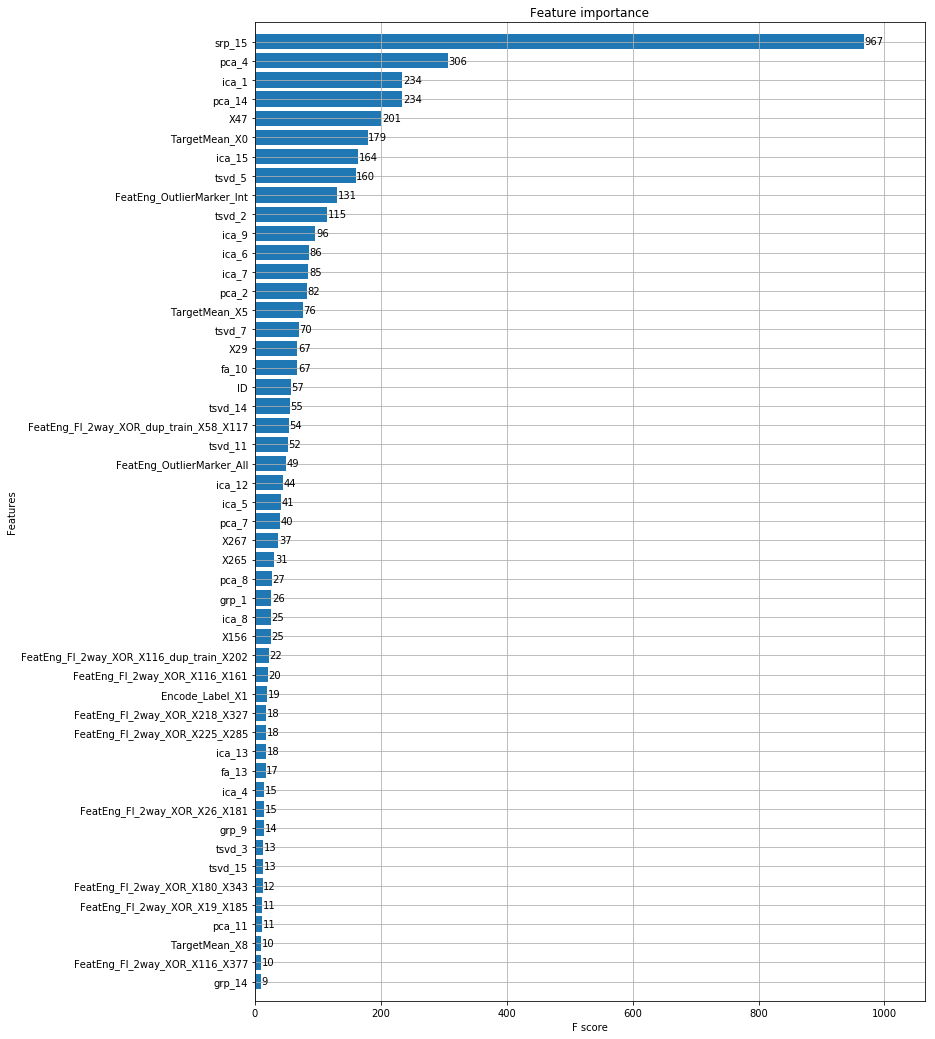

In [35]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()